In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
file_path = 'data_input_auto/山东汽油裂解差1.xlsx'
excel_data = pd.ExcelFile(file_path)
sheet = excel_data.parse('Sheet1')

sheet.columns = ['Date', '山东汽油裂解差', '中国独立炼厂汽油库存']
sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')
sheet = sheet[sheet['Date'] >= '2023-08-01']
sheet.tail()


,Date,山东汽油裂解差,中国独立炼厂汽油库存
2097,2025-04-24,976.3823,NaN
2098,2025-04-25,966.3029,78.8272
2099,2025-04-27,946.7247,NaN
2100,2025-04-28,948.4670,NaN
2101,2025-04-29,944.9824,NaN


In [4]:
file_path1  = 'data_output_auto/中国独立炼厂汽油库存预测.xlsx'
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1.rename(columns={'DataTime': 'Date'}, inplace=True)
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1.head()

,Date,中国独立炼厂汽油库存
0,2025-05-03,81.694088
1,2025-05-04,82.309681
2,2025-05-05,82.805858
3,2025-05-06,83.740833
4,2025-05-07,83.965526


In [5]:
file_path2  = 'eta/山东汽油裂解差拟合残差-中国独立炼厂汽油库存_合并数据.xlsx'
sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
sheet2.rename(columns={'DataTime': 'Date'}, inplace=True)
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2['山东汽油裂解差拟合残差-中国独立炼厂汽油库存'] = sheet2['真实值'].combine_first(sheet2['预测值'])
sheet2.head()

,Date,真实值,预测值,山东汽油裂解差拟合残差-中国独立炼厂汽油库存
0,2025-06-06,NaN,31.8900,31.8900
1,2025-06-05,NaN,86.2796,86.2796
2,2025-06-04,NaN,141.4127,141.4127
3,2025-06-03,NaN,143.9105,143.9105
4,2025-06-02,NaN,149.6116,149.6116


In [6]:
# 使用 outer merge 合并两个数据表，以 Date 为键
merged_sheet = pd.merge(sheet, sheet1, 
                       on='Date', 
                       how='outer',
                       suffixes=('', '_y'))

# 使用 coalesce 填充空值，优先使用原始值，如果为空则使用另一个表的值
merged_sheet['中国独立炼厂汽油库存'] = merged_sheet['中国独立炼厂汽油库存'].combine_first(merged_sheet['中国独立炼厂汽油库存_y'])

# 删除多余的列
merged_sheet = merged_sheet.drop(columns=['中国独立炼厂汽油库存_y'])

# 按日期排序
merged_sheet = merged_sheet.sort_values('Date')

merged_sheet.tail()

,Date,山东汽油裂解差,中国独立炼厂汽油库存
467,2025-05-26,NaN,83.787350
468,2025-05-27,NaN,83.958584
469,2025-05-28,NaN,83.967518
470,2025-05-29,NaN,83.590992
471,2025-05-30,NaN,83.590992


In [7]:
last_day = merged_sheet['Date'][merged_sheet['山东汽油裂解差'].last_valid_index()]

sheet_daily = merged_sheet.copy()
sheet_daily.loc[sheet_daily['Date'] <= last_day, '山东汽油裂解差'] = sheet_daily.loc[sheet_daily['Date'] <= last_day, '山东汽油裂解差'].interpolate(method='linear')

sheet_daily['中国独立炼厂汽油库存'] = sheet_daily['中国独立炼厂汽油库存'].interpolate(method='linear')

sheet_daily.tail() 

,Date,山东汽油裂解差,中国独立炼厂汽油库存
467,2025-05-26,NaN,83.787350
468,2025-05-27,NaN,83.958584
469,2025-05-28,NaN,83.967518
470,2025-05-29,NaN,83.590992
471,2025-05-30,NaN,83.590992


In [8]:
# 合并 sheet2 中的残差数据到 sheet_daily
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '山东汽油裂解差拟合残差-中国独立炼厂汽油库存']],
    on='Date',
    how='left'
)

# 按照 sheet_daily 的时间顺序排序
sheet_daily = sheet_daily.sort_values('Date')

# 对新加入的列进行线性插值填充空值
sheet_daily['山东汽油裂解差拟合残差-中国独立炼厂汽油库存'] = sheet_daily['山东汽油裂解差拟合残差-中国独立炼厂汽油库存'].interpolate(method='linear')
sheet_daily.tail()

,Date,山东汽油裂解差,中国独立炼厂汽油库存,山东汽油裂解差拟合残差-中国独立炼厂汽油库存
467,2025-05-26,NaN,83.787350,231.8414
468,2025-05-27,NaN,83.958584,237.6344
469,2025-05-28,NaN,83.967518,239.4310
470,2025-05-29,NaN,83.590992,127.0258
471,2025-05-30,NaN,83.590992,139.1586


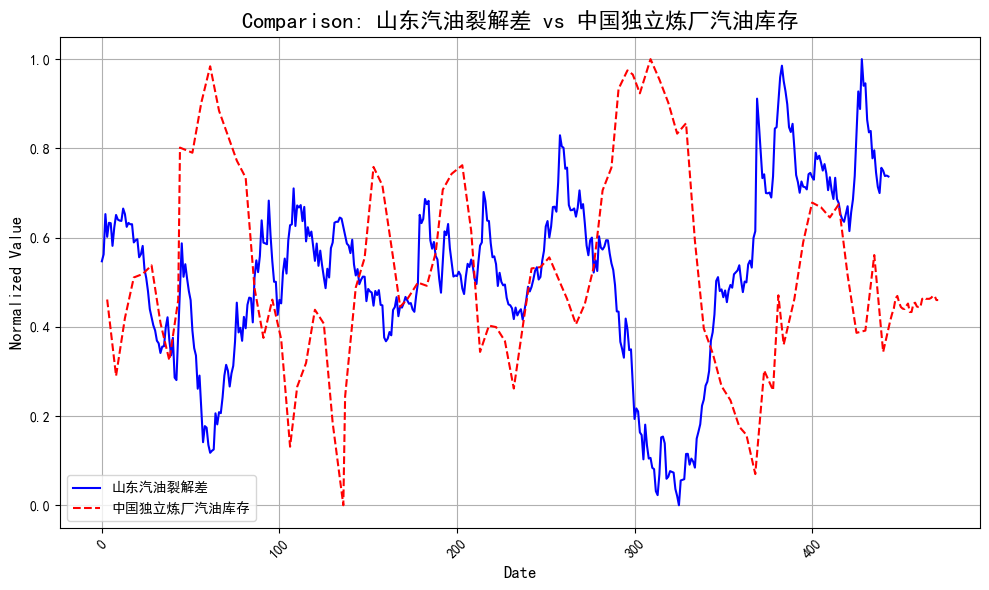

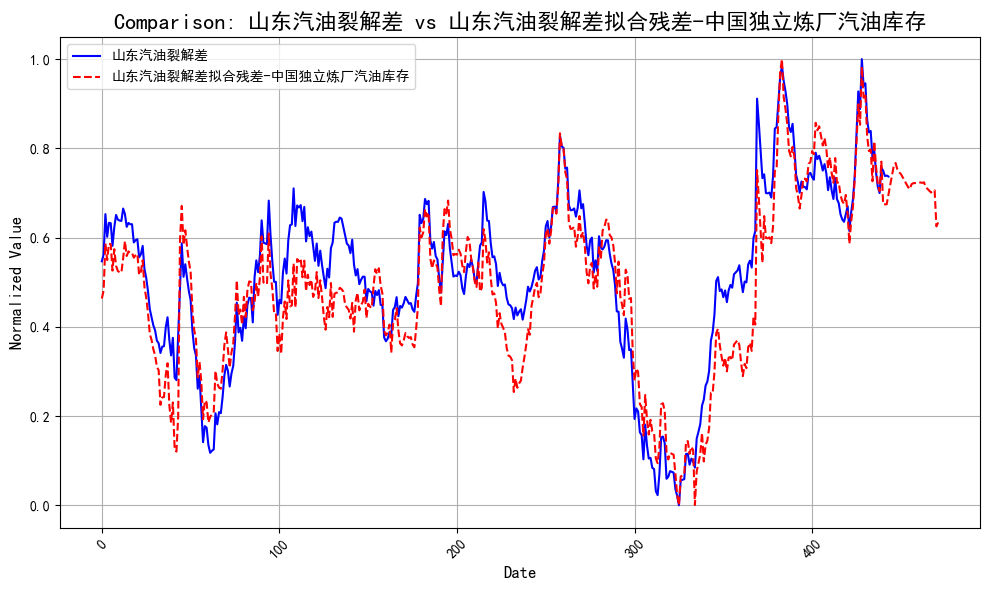

In [9]:
plot_comparison_multiple(
    sheet_daily, 
    main_col='山东汽油裂解差', 
    compare_cols=['中国独立炼厂汽油库存','山东汽油裂解差拟合残差-中国独立炼厂汽油库存']
)

---

In [10]:
# 添加新列 山东汽油裂解差_预测
sheet_daily['山东汽油裂解差_预测'] = -13.729* sheet_daily['中国独立炼厂汽油库存'] + 1853.1136 + sheet_daily['山东汽油裂解差拟合残差-中国独立炼厂汽油库存']
sheet_daily.tail()

,Date,山东汽油裂解差,中国独立炼厂汽油库存,山东汽油裂解差拟合残差-中国独立炼厂汽油库存,山东汽油裂解差_预测
467,2025-05-26,NaN,83.787350,231.8414,934.638478
468,2025-05-27,NaN,83.958584,237.6344,938.080605
469,2025-05-28,NaN,83.967518,239.4310,939.754549
470,2025-05-29,NaN,83.590992,127.0258,832.518673
471,2025-05-30,NaN,83.590992,139.1586,844.651473


In [11]:
last_day = sheet_daily['Date'][sheet_daily['山东汽油裂解差'].last_valid_index()]


# 创建每日数据框
merged_df_daily = pd.DataFrame()
merged_df_daily['Date'] = sheet_daily['Date']
merged_df_daily['真实值'] = sheet_daily['山东汽油裂解差']
merged_df_daily['预测值'] = None

# 在last_day之后填充预测值
mask = merged_df_daily['Date'] > last_day
merged_df_daily.loc[mask, '预测值'] = sheet_daily.loc[mask, '山东汽油裂解差_预测']

# 创建月度数据框 
merged_df_montly = pd.DataFrame()
merged_df_montly['Date'] = sheet_daily['Date']
merged_df_montly['真实值'] = sheet_daily['山东汽油裂解差']
merged_df_montly['预测值'] = None

# 在2024-01-01之后填充预测值
mask = merged_df_montly['Date'] > '2024-01-01'
merged_df_montly.loc[mask, '预测值'] = sheet_daily.loc[mask, '山东汽油裂解差_预测']


In [12]:
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/山东汽油裂解差_合并数据.xlsx', index=False,float_format='%.4f')
merged_df_daily

,Date,真实值,预测值
471,2025/05/30,NaN,844.651473
470,2025/05/29,NaN,832.518673
469,2025/05/28,NaN,939.754549
468,2025/05/27,NaN,938.080605
467,2025/05/26,NaN,934.638478
...,...,...,...
4,2023/08/07,778.0039,None
3,2023/08/04,727.4173,None
2,2023/08/03,809.3668,None
1,2023/08/02,663.9316,None


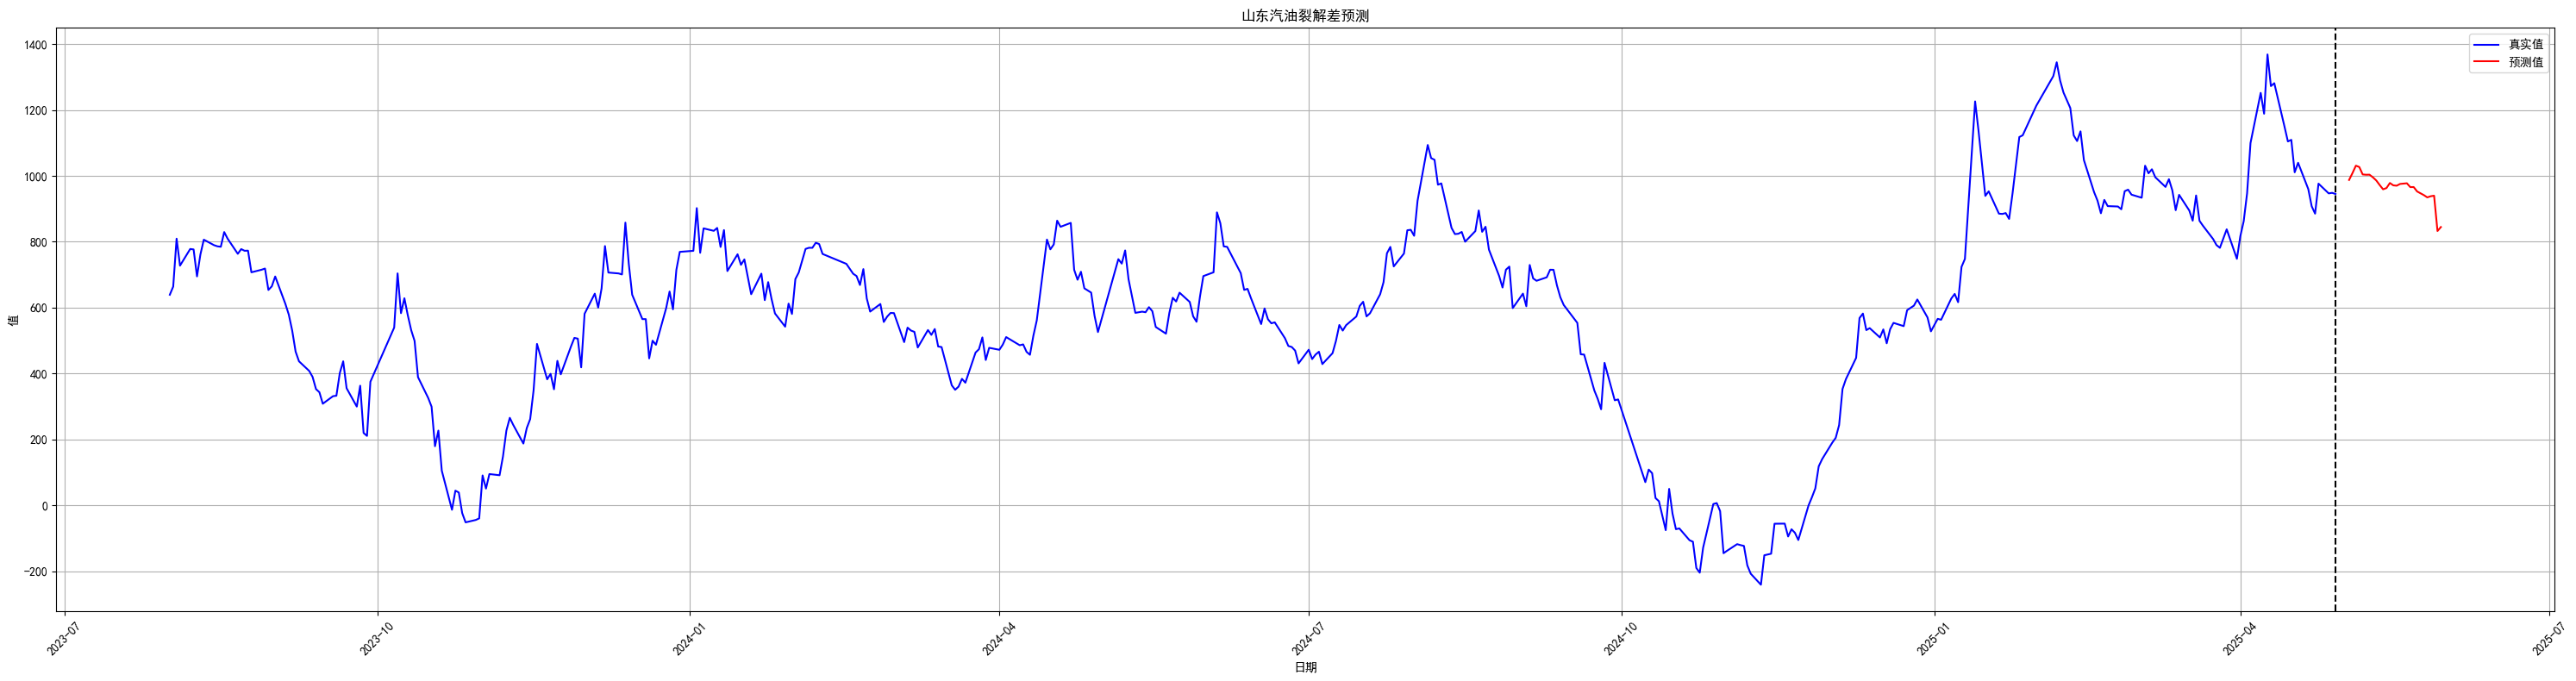

In [13]:
# 设置图形大小
plt.figure(figsize=(30, 8))
merged_df_daily_plot = merged_df_daily
# 将日期格式转换回datetime格式用于绘图
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])
# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['真实值'], color='blue', label='真实值')
# 绘制预测值曲线(红色) 
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['预测值'], color='red', label='预测值')
# 计算并绘制中间垂直线(黑色)
avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')
plt.legend()

# 设置标题和标签
plt.title('山东汽油裂解差预测')
plt.xlabel('日期')
plt.ylabel('值')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
merged_df_montly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_montly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/山东汽油裂解差_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly

,Date,真实值,预测值
22,2025/06/30,NaN,960.50082
21,2025/05/31,NaN,966.152536
20,2025/04/30,1047.143223,1058.32824
19,2025/03/31,901.176938,910.578654
18,2025/02/28,1055.993384,1038.931208
17,2025/01/31,885.323823,872.19321
16,2024/12/31,487.693741,499.29143
15,2024/11/30,-81.611433,-54.52579
14,2024/10/31,-29.009742,-29.14105
13,2024/09/30,536.894957,515.913093


---

In [15]:
'''
# 创建新的 DataFrame,只包含有预测值的数据
df_prediction = pd.DataFrame()
df_prediction['Date'] = merged_df_daily[merged_df_daily['预测值'].notna()]['Date']
df_prediction['山东汽油裂解差_预测'] = merged_df_daily[merged_df_daily['预测值'].notna()]['预测值']
df_prediction['Date'] = pd.to_datetime(df_prediction['Date']).dt.strftime('%Y-%m-%d')
# 保存到Excel
df_prediction.to_csv('data_output_auto/山东汽油裂解差_未来日度预测.csv', index=False)
df_prediction.head()
'''

"\n# 创建新的 DataFrame,只包含有预测值的数据\ndf_prediction = pd.DataFrame()\ndf_prediction['Date'] = merged_df_daily[merged_df_daily['预测值'].notna()]['Date']\ndf_prediction['山东汽油裂解差_预测'] = merged_df_daily[merged_df_daily['预测值'].notna()]['预测值']\ndf_prediction['Date'] = pd.to_datetime(df_prediction['Date']).dt.strftime('%Y-%m-%d')\n# 保存到Excel\ndf_prediction.to_csv('data_output_auto/山东汽油裂解差_未来日度预测.csv', index=False)\ndf_prediction.head()\n"

In [16]:
'''
df_prediction_monthly= merged_df_monthly[['Date','预测值']].copy()
df_prediction_monthly['Date'] = pd.to_datetime(df_prediction_monthly['Date'])
df_prediction_monthly['Date'] = df_prediction_monthly['Date'].dt.strftime('%Y-%m-%d')

# 保存到CSV文件
df_prediction_monthly.to_csv('data_output_auto/山东汽油裂解差_2024月度预测.csv', index=False)
df_prediction_monthly.head()
'''

"\ndf_prediction_monthly= merged_df_monthly[['Date','预测值']].copy()\ndf_prediction_monthly['Date'] = pd.to_datetime(df_prediction_monthly['Date'])\ndf_prediction_monthly['Date'] = df_prediction_monthly['Date'].dt.strftime('%Y-%m-%d')\n\n# 保存到CSV文件\ndf_prediction_monthly.to_csv('data_output_auto/山东汽油裂解差_2024月度预测.csv', index=False)\ndf_prediction_monthly.head()\n"

---

In [17]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "山东汽油裂解"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [18]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "山东汽油裂解"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/04/30)
数据已成功更新到Excel文件
